<a href="https://colab.research.google.com/github/cleziac/Movie-Recommendation/blob/main/contextual_MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

The procedure is aims at preparing the dataset in the shape needed in the mab2rec library.

In [1]:
!pip3 install mab2rec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
from mab2rec.utils import print_interaction_stats

import os
os.chdir('..')

import warnings
warnings.filterwarnings("ignore")

In [10]:
ratings = pd.read_csv('/content/drive/MyDrive/data/ratings.csv')

ratings.head(2)

,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [4]:
ratings.drop('timestamp', axis = 1, inplace = True)

In [5]:
print('Min user_id: ', ratings.user_id.min())
print('Max user_id: ', ratings.user_id.max())
print('Min movie_id: ', ratings.movie_id.min())
print('Max movie_id: ', ratings.movie_id.max())

Min user_id:  1
Max user_id:  610
Min movie_id:  1
Max movie_id:  193609


Now, in order to keep a limited amount of rows in the dataframe, I will keep only movies which have been rated at least 20 times.

In [19]:
ratings_small = ratings[ratings['movie_id'].map(ratings['movie_id'].value_counts()) > 20]

In [20]:
ratings_small.nunique()

user_id        610
movie_id      1235
rating          10
timestamp    56718
dtype: int64

In [21]:
ratings_small

,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100803,610,148626,4.0,1493847175
100808,610,152081,4.0,1493846503
100829,610,164179,5.0,1493845631
100830,610,166528,4.0,1493879365


In [22]:
ratings_small.drop('timestamp', axis = 1, inplace = True)

In [70]:
ratings_small.to_csv('/content/drive/MyDrive/data/bandits rec/ratings_small.csv', index = False)

Okay, so now I will have to maintain the filter on both the features dataset and the users dataset.

[The users excluded from the filter will not be present in the users dataset, same goes for the movie].

This should yield 610 unique users and 1235 unique movies.

Keeping only the movies that have been rated at least 20 times:

In [54]:
users = pd.read_csv('/content/drive/MyDrive/data/u.user',
                    sep = '|',
                    names = ['user_id', 'age', 'gender', 'occupation', 'zipcode'])

In [55]:
users

,user_id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [56]:
users_small = users[users['user_id'].isin(ratings_small['user_id'])]

In [57]:
users_small

,user_id,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
605,606,28,M,programmer,63044
606,607,49,F,healthcare,02154
607,608,22,M,other,10003
608,609,13,F,student,55106


In [58]:
users_small.drop('zipcode', axis = 1, inplace = True)

In [59]:
users_small

,user_id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other
...,...,...,...,...
605,606,28,M,programmer
606,607,49,F,healthcare
607,608,22,M,other
608,609,13,F,student


Now, the age is a feature I do want to keep but creating dummies on all the unique values would create a dataframe that's too big. I will create a mapping to group the users into different age fields.

In [60]:
bins = [0, 18, 25, 40, 60, max(users_small['age'])]
labels = ['Teen', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']

users_small['age_range'] = pd.cut(users_small['age'], bins=bins, labels=labels)

In [61]:
users_small

,user_id,age,gender,occupation,age_range
0,1,24,M,technician,Young Adult
1,2,53,F,other,Middle Aged
2,3,23,M,writer,Young Adult
3,4,24,M,technician,Young Adult
4,5,33,F,other,Adult
...,...,...,...,...,...
605,606,28,M,programmer,Adult
606,607,49,F,healthcare,Middle Aged
607,608,22,M,other,Young Adult
608,609,13,F,student,Teen


Now we can drop the age column and get the dummy variables for all the different values in the 'occupation', 'age_range' and 'gender' columns.  

In [62]:
users_small.drop('age', axis = 1, inplace = True)

In [63]:
users_small = pd.get_dummies(users_small, columns = ['gender', 'occupation', 'age_range'])

In [64]:
users_small

,user_id,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,age_range_Teen,age_range_Young Adult,age_range_Adult,age_range_Middle Aged,age_range_Senior
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
606,607,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
607,608,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
608,609,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [37]:
users_small.columns

Index(['user_id', 'gender_F', 'gender_M', 'occupation_administrator',
       'occupation_artist', 'occupation_doctor', 'occupation_educator',
       'occupation_engineer', 'occupation_entertainment',
       'occupation_executive', 'occupation_healthcare', 'occupation_homemaker',
       'occupation_lawyer', 'occupation_librarian', 'occupation_marketing',
       'occupation_none', 'occupation_other', 'occupation_programmer',
       'occupation_retired', 'occupation_salesman', 'occupation_scientist',
       'occupation_student', 'occupation_technician', 'occupation_writer',
       'age_range_Teen', 'age_range_Young Adult', 'age_range_Adult',
       'age_range_Middle Aged', 'age_range_Senior'],
      dtype='object')

In [65]:
# mapping the column names into the right 'format'

users_small.rename(columns = {
    'user_id' : 'user_id',
    'gender_F' : 'u0',
    'gender_M' : 'u1',
    'occupation_administrator' : 'u2',
    'occupation_artist' : 'u3',
    'occupation_doctor' : 'u4',
    'occupation_educator' : 'u5',
    'occupation_engineer' : 'u6',
    'occupation_entertainment' : 'u7',
    'occupation_executive' : 'u8',
    'occupation_healthcare' : 'u9',
    'occupation_homemaker' : 'u10',
    'occupation_lawyer' : 'u11',
    'occupation_librarian' : 'u12',
    'occupation_marketing' : 'u13',
    'occupation_none' : 'u14',
    'occupation_other' : 'u15',
    'occupation_programmer' : 'u16',
    'occupation_retired' : 'u17',
    'occupation_salesman' : 'u18',
    'occupation_scientist' : 'u19',
    'occupation_student' : 'u20',
    'occupation_technician' : 'u21',
    'occupation_writer' : 'u22',
    'age_range_Teen' : 'u23',
    'age_range_Young Adult' : 'u24',
    'age_range_Adult' : 'u25',
    'age_range_Middle Aged' : 'u26',
    'age_range_Senior' : 'u27'
}, inplace = True)

In [66]:
users_small

,user_id,u0,u1,u2,u3,u4,u5,u6,u7,u8,...,u18,u19,u20,u21,u22,u23,u24,u25,u26,u27
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,4,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,606,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
606,607,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
607,608,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
608,609,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [67]:
users_small.to_csv('/content/drive/MyDrive/data/bandits rec/users_small.csv', index = False)

Now the same process goes for the movies...

In [42]:
movies = pd.read_csv('/content/drive/MyDrive/data/bandits rec/movies.csv')

movies.head(2)

,movie_id,movie_name,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [ ]:
movies.drop('movie_name', axis = 1, inplace = True)

In [44]:
movies_small = movies[movies['movie_id'].isin(ratings_small['movie_id'])]

Let's drop the title and create dummy variables around the 'tag' column, which represents the genres.

In [47]:
movies_small = movies.drop('tag', axis=1).join(movies['tag'].str.get_dummies(sep='|'))

In [48]:
movies_small

,movie_id,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9740,193587,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
movies_small.columns

Index(['movie_id', '(no genres listed)', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [50]:
movies_small.rename(columns = {
    'movie_id' : 'movie_id',
    '(no genres listed)' : 'i0',
    'Action' : 'i1',
    'Adventure' : 'i2',
    'Animation' : 'i3',
    'Children' : 'i4',
    'Comedy' : 'i5',
    'Crime' : 'i6',
    'Documentary' : 'i7',
    'Drama' : 'i8',
    'Fantasy' : 'i9',
    'Film-Noir' : 'i10',
    'Horror' : 'i11',
    'IMAX' : 'i12',
    'Musical' : 'i13',
    'Mystery' : 'i14',
    'Romance' : 'i15',
    'Sci-Fi' : 'i16',
    'Thriller' : 'i17',
    'War' : 'i18',
    'Western' : 'i19'
}, inplace = True)

In [68]:
movies_small

,movie_id,i0,i1,i2,i3,i4,i5,i6,i7,i8,...,i10,i11,i12,i13,i14,i15,i16,i17,i18,i19
0,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9740,193587,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
movies_small.columns

Index(['item_id', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9',
       'i10', 'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17', 'i18', 'i19'],
      dtype='object')

In [107]:
movies_small.rename(columns = {
    'movie_id' : 'item_id',
    'i0' : 'i0', 'i1' : 'i1', 'i2' : 'i2', 'i3' : 'i3', 'i4' : 'i4', 'i5' : 'i5', 'i6' : 'i6', 'i7' : 'i7',
    'i8' : 'i8', 'i9' : 'i9', 'i10' : 'i10', 'i11' : 'i11', 'i12' : 'i12',
    'i13' : 'i13', 'i14' : 'i14', 'i15' : 'i15', 'i16' : 'i16', 'i17' : 'i17', 'i18' : 'i18', 'i19' : 'i19'
}, inplace = True)

In [109]:
movies_small.to_csv('/content/drive/MyDrive/data/bandits rec/movies_small.csv', index = False)

Now, the final step: creating an interaction dataframe where the columns are the user_id, the item_id and the response, where:

- response = 1 if a user_id has provided a rating to an item_id;
- response = 0 otherwise.

In [71]:
ratings_small.head(2)

,user_id,movie_id,rating
0,1,1,4.0
1,1,3,4.0


In [72]:
interactions = ratings_small.pivot_table(index='movie_id', columns='user_id', aggfunc=len, fill_value=0)

In [73]:
interactions

rating                                      ...                      \
user_id     1   2   3   4   5   6   7   8   9   10   ... 601 602 603 604 605   
movie_id                                             ...                       
1             1   0   0   0   1   0   1   0   0   0  ...   1   0   1   1   1   
2             0   0   0   0   0   1   0   1   0   0  ...   0   1   0   1   1   
3             1   0   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   
5             0   0   0   0   0   1   0   0   0   0  ...   0   0   0   1   0   
6             1   0   0   0   0   1   0   0   0   0  ...   0   1   1   1   0   
...         ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..   
148626        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
152081        0   0   0   0   0   0   0   0   0   0  ...   1   0   0   0   0   
164179        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
166528        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
168252        0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   

                              
user_id  606 607 608 609 610  
movie_id                      
1          1   1   1   1   1  
2          0   0   1   0   0  
3          0   0   1   0   0  
5          0   0   0   0   0  
6          0   0   0   0   1  
...       ..  ..  ..  ..  ..  
148626     0   0   0   0   1  
152081     0   0   0   0   1  
164179     0   0   0   0   1  
166528     0   0   0   0   1  
168252     0   0   0   0   1  

[1235 rows x 610 columns]

In [74]:
inter = interactions.reset_index()

In [75]:
inter

movie_id rating                          ...                          \
user_id               1  2  3  4  5  6  7  8  9  ... 601 602 603 604 605 606   
0              1      1  0  0  0  1  0  1  0  0  ...   1   0   1   1   1   1   
1              2      0  0  0  0  0  1  0  1  0  ...   0   1   0   1   1   0   
2              3      1  0  0  0  0  1  0  0  0  ...   0   0   0   0   0   0   
3              5      0  0  0  0  0  1  0  0  0  ...   0   0   0   1   0   0   
4              6      1  0  0  0  0  1  0  0  0  ...   0   1   1   1   0   0   
...          ...    ... .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..   
1230      148626      0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
1231      152081      0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   
1232      164179      0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
1233      166528      0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   
1234      168252      0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   

                         
user_id 607 608 609 610  
0         1   1   1   1  
1         0   1   0   0  
2         0   1   0   0  
3         0   0   0   0  
4         0   0   0   1  
...      ..  ..  ..  ..  
1230      0   0   0   1  
1231      0   0   0   1  
1232      0   0   0   1  
1233      0   0   0   1  
1234      0   0   0   1  

[1235 rows x 611 columns]

In [76]:
inter = interactions.stack()

In [77]:
inter

rating
movie_id user_id        
1        1             1
         2             0
         3             0
         4             0
         5             1
...                  ...
168252   606           0
         607           0
         608           0
         609           0
         610           1

[753350 rows x 1 columns]

In [78]:
inter.reset_index(inplace = True)

In [79]:
inter

,movie_id,user_id,rating
0,1,1,1
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,1
...,...,...,...
753345,168252,606,0
753346,168252,607,0
753347,168252,608,0
753348,168252,609,0


In [82]:
inter = inter[['user_id', 'movie_id', 'rating']]

In [83]:
inter.rename(columns = {
    'user_id' : 'user_id',
    'movie_id' : 'item_id',
    'rating' : 'response'
}, inplace = True)

In [84]:
inter

,user_id,item_id,response
0,1,1,1
1,2,1,0
2,3,1,0
3,4,1,0
4,5,1,1
...,...,...,...
753345,606,168252,0
753346,607,168252,0
753347,608,168252,0
753348,609,168252,0


In [85]:
inter.to_csv('/content/drive/MyDrive/data/bandits rec/interaction_small.csv', index = False)

Train and test split. 25% will be kept as testing data. The train test split function from sklearn will be used. The data is going to be shuffled in order to avoid the bias added from the preprocessing operations (by stacking the responses in a dataframe, the movies follow and order together with the users).

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
data_train, data_test = train_test_split(inter, test_size = 0.25, shuffle = True)

In [88]:
print("=== TRAIN ===")
print_interaction_stats(data_train)

print("=== TEST ===")
print_interaction_stats(data_test)

=== TRAIN ===
Number of rows: 565,012
Number of users: 610
Number of items: 1,235
Mean response rate: 0.0888

=== TEST ===
Number of rows: 188,338
Number of users: 610
Number of items: 1,235
Mean response rate: 0.0877



In [89]:
from mab2rec import BanditRecommender, LearningPolicy, NeighborhoodPolicy

In [97]:
# Set of recommenders to benchmark
recommenders = {
      "Random": BanditRecommender(learning_policy=LearningPolicy.Random()),
      "LinGreedy": BanditRecommender(learning_policy=LearningPolicy.LinGreedy(epsilon=0.1)),
      "LinUCB": BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=10)),
      "LinTS": BanditRecommender(learning_policy=LearningPolicy.LinTS()),
      "ClustersTS" : BanditRecommender(learning_policy=LearningPolicy.ThompsonSampling(),
                                       neighborhood_policy = NeighborhoodPolicy.Clusters(n_clusters = 10))
}

recommenders

{'Random': <mab2rec.rec.BanditRecommender at 0x7889f8429870>,
 'LinGreedy': <mab2rec.rec.BanditRecommender at 0x7889f842af80>,
 'LinUCB': <mab2rec.rec.BanditRecommender at 0x7889f8429330>,
 'LinTS': <mab2rec.rec.BanditRecommender at 0x7889f8429210>,
 'ClustersTS': <mab2rec.rec.BanditRecommender at 0x7889f842bd90>}

In [96]:
from jurity.recommenders import BinaryRecoMetrics, RankingRecoMetrics

# Column names for the response, user, and item id columns
metric_params = {'click_column': 'score', 'user_id_column': 'user_id', 'item_id_column':'item_id'}

# Evaluate peformance at different k-recommendations
top_k_list = [3, 5, 10]

# List of metrics to benchmark
metrics = []
for k in top_k_list:
    metrics.append(BinaryRecoMetrics.AUC(**metric_params, k=k))
    metrics.append(BinaryRecoMetrics.CTR(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.Precision(**metric_params,  k=k))
    metrics.append(RankingRecoMetrics.Recall(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.NDCG(**metric_params, k=k))
    metrics.append(RankingRecoMetrics.MAP(**metric_params, k=k))

metrics

In [93]:
from mab2rec.pipeline import benchmark

In [92]:
user_features = '/content/drive/MyDrive/data/bandits rec/users_small.csv'

In [98]:
# Benchmark the set of recommenders for the list of metrics
# using training data and user features with cross-validation
reco_to_results, reco_to_metrics = benchmark(recommenders,
                                             metrics=metrics,
                                             train_data=data_train,
                                             cv=None,
                                             test_data = data_test,
                                             user_features=user_features)

# Evaluation metrics


Great! We now have the recommended results, reco_to_results, and the evaluation metrics for each of the algorithms, reco_to_metrics.
Next, we perform a detailed analysis to confirm that the algorithms are behaving as expected.
We compare the relative performance of the algorithms using a range of metrics.


We start by analyzing standard recommender metrics such as CTR, Precision, Recall and NDCG.
Each plot displays the value (y-axis) of a given metric at different top-k (x-axis) for each of the algorithms (different lines).
We observe that LinGreedy performs as well as ClustersTS.


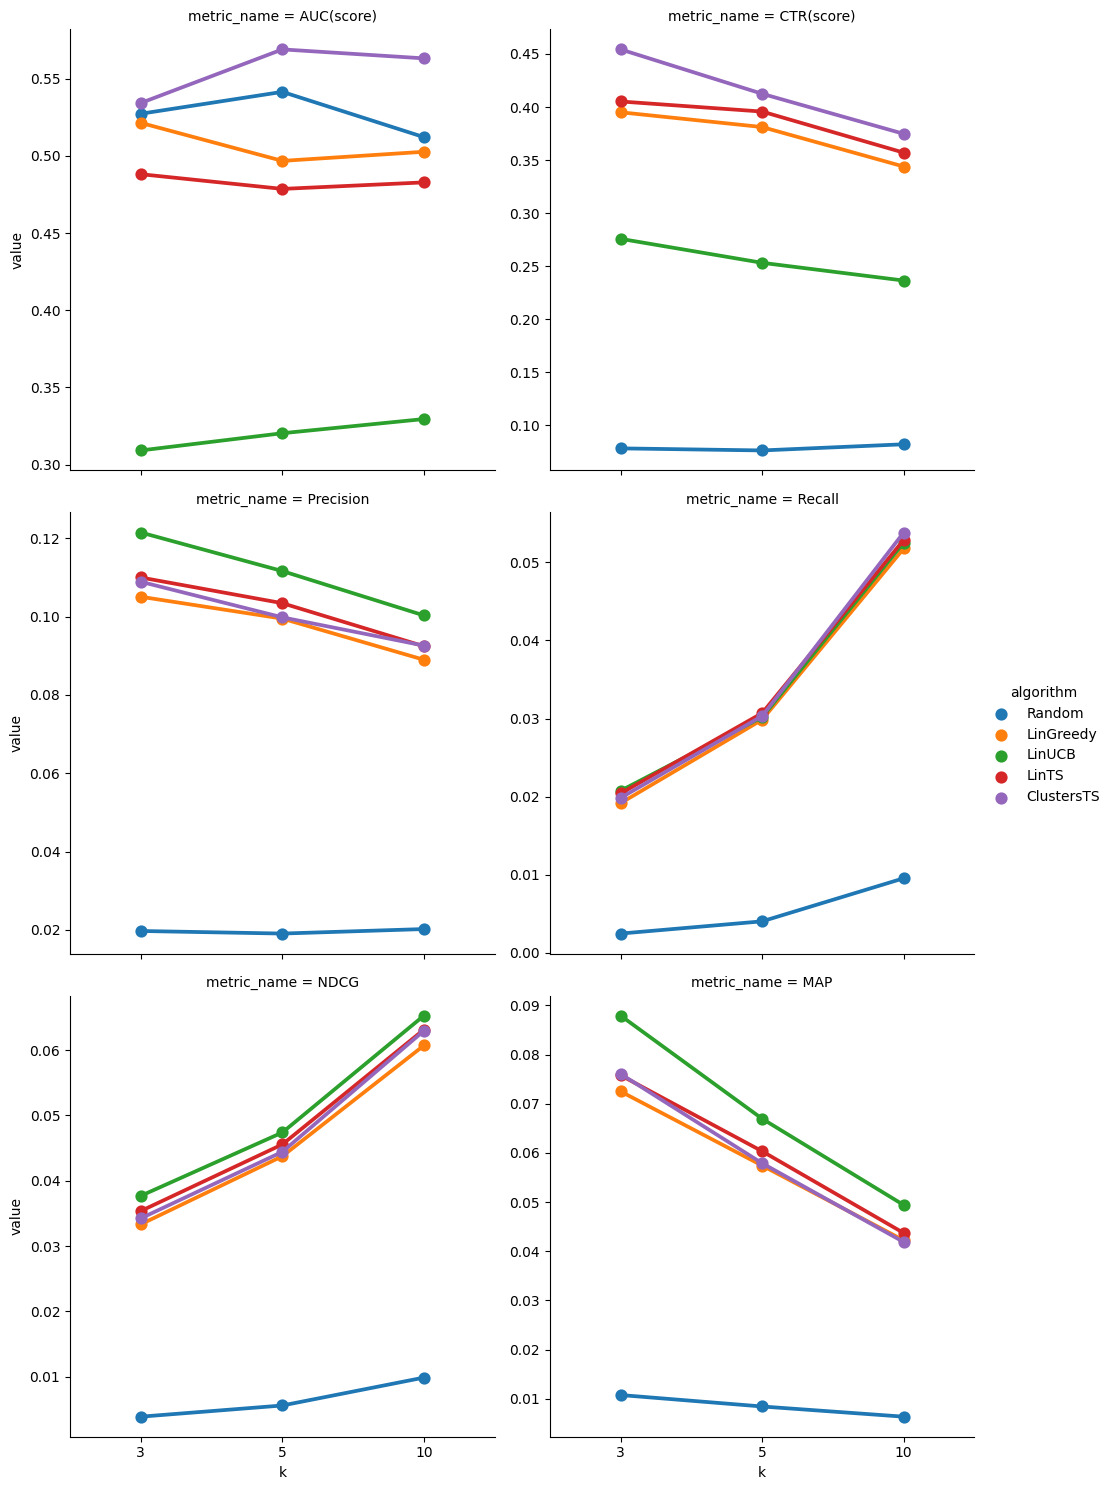

In [99]:
from mab2rec.visualization import plot_metrics_at_k

# Plot each metric across all algorithms at different k
plot_metrics_at_k(reco_to_metrics, col_wrap=2);

Here we evaluate **Inter-list Diversity** for each algorithm.
The metric shows how diverse recommendations are between users.

A low value suggests that many users are receiving the same or similar recommendations.

A high value suggests that users are receiving different or diverse recommendations.

As expected, the diversity of random recommendation is very high.


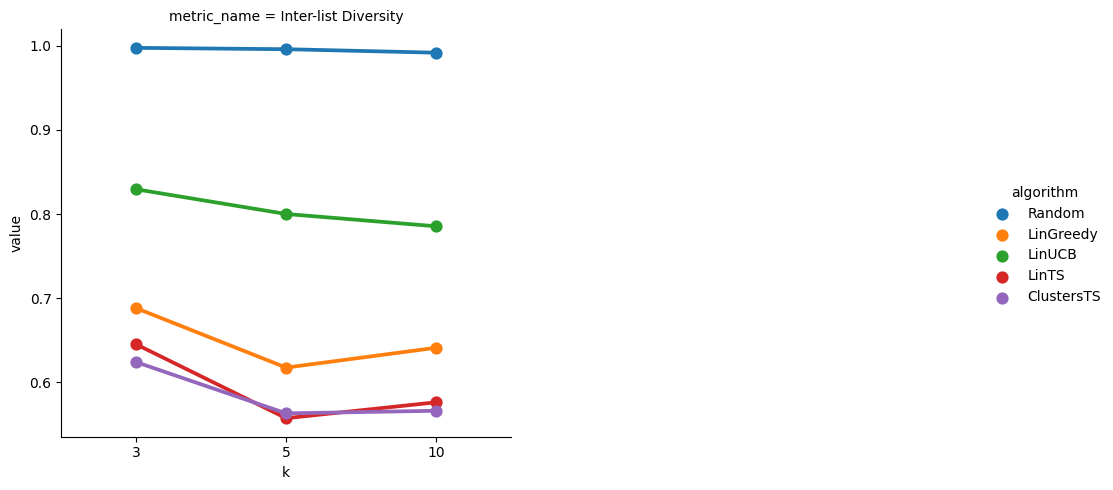

In [100]:
from mab2rec.visualization import plot_inter_diversity_at_k

plot_inter_diversity_at_k(reco_to_results, k_list = [3, 5, 10], col_wrap = 2);

The **Intra-list diversity metric** measures the diversity of items within each recommendation, at different levels of k.

The similarity between different items are calculated based on the item features/embeddings.

A low value for this metric suggests that the items included in the top-k recommendation are very similar.

Again we observe highest diversity from random recommendation.

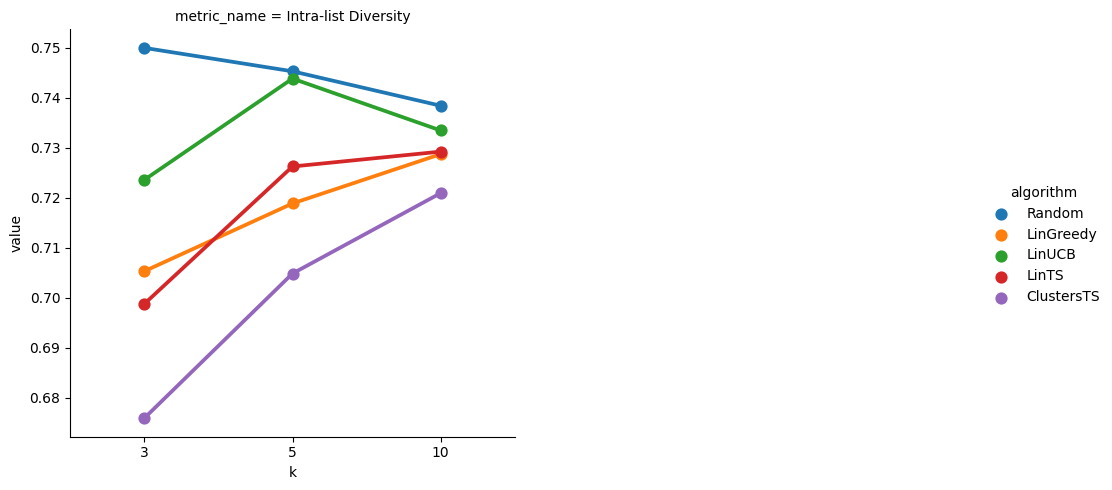

In [110]:
from mab2rec.visualization import plot_intra_diversity_at_k

plot_intra_diversity_at_k(reco_to_results, item_features = movies_small, k_list = [3, 5, 10], col_wrap = 2);

**Recommendation Counts vs. Ground Truth**

In these scatter plots each dot represents an item.

The plot shows the number of times the item was recommended (y-axis) vs. number of times the item occured (x-axis) in the test data.

Items above the red line were recommended more often than it occurred in the test data, whereas items below the red line were recommended less often.

LinGreedy tends to recommend items more frequently.

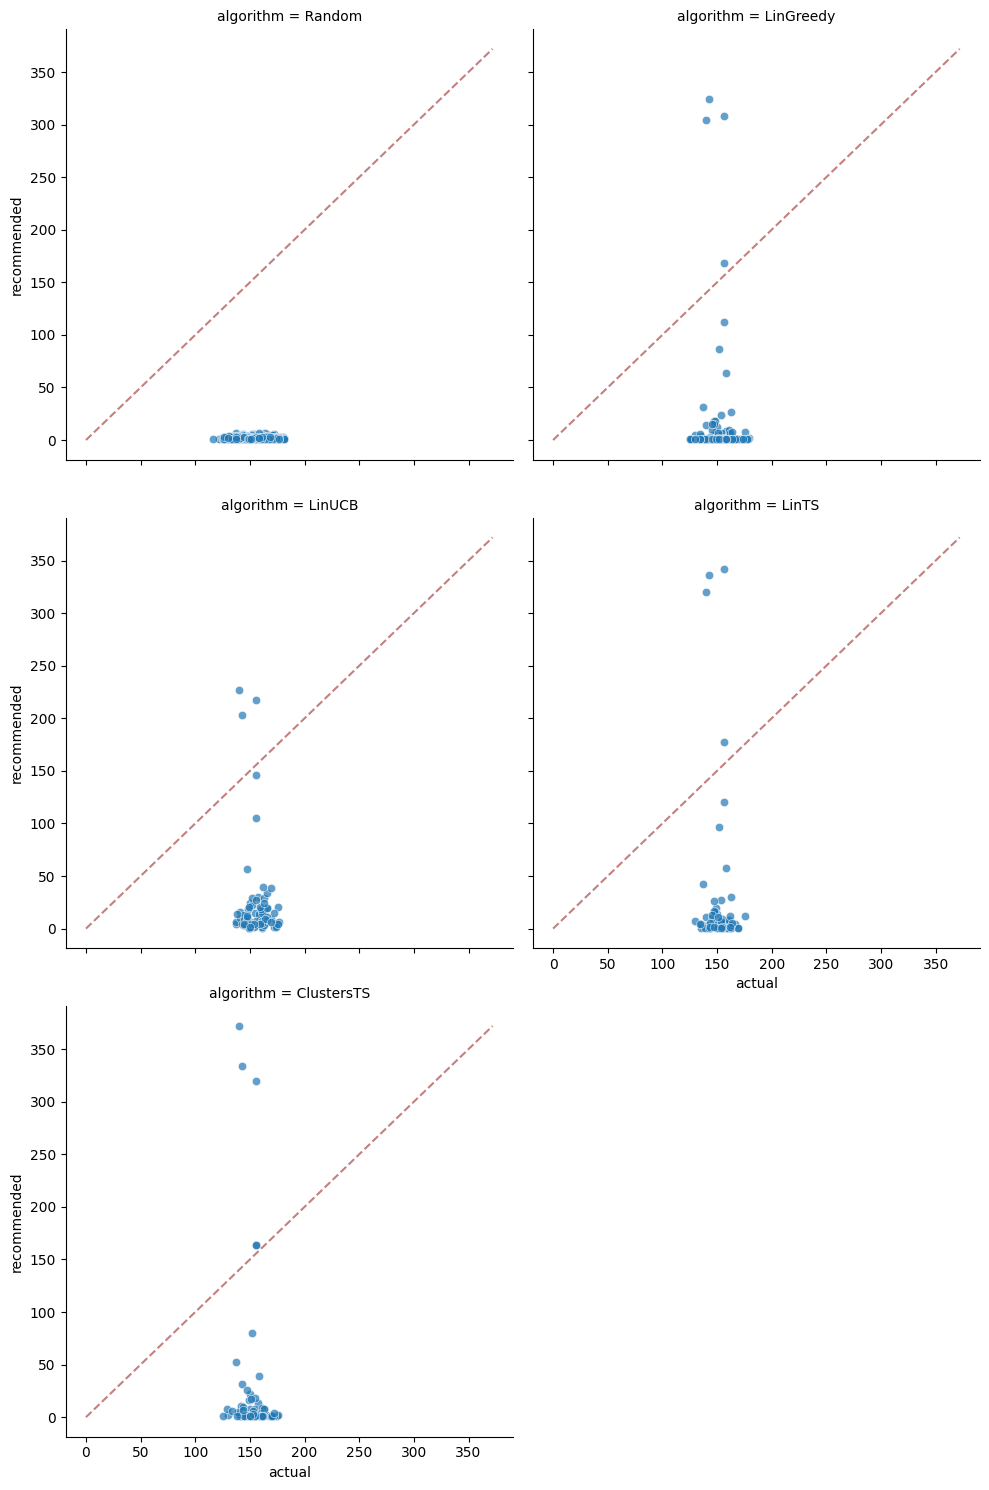

In [111]:
from mab2rec.visualization import plot_recommended_counts

plot_recommended_counts(reco_to_results, data_test, k = 3, alpha = 0.7, average_response = False, col_wrap = 2);



Next we look at the scatter plots that shows the number of times the item was recommended (y-axis) in the test data and the average response for that item (x-axis) the test data.

As expected, recommendation counts for Random quite uniform and have no association with average ground truth responses.

For LinGreedy and ClustersTS there appears to be a positive association between recommendation counts and the average ground truth response for the other algorithms.

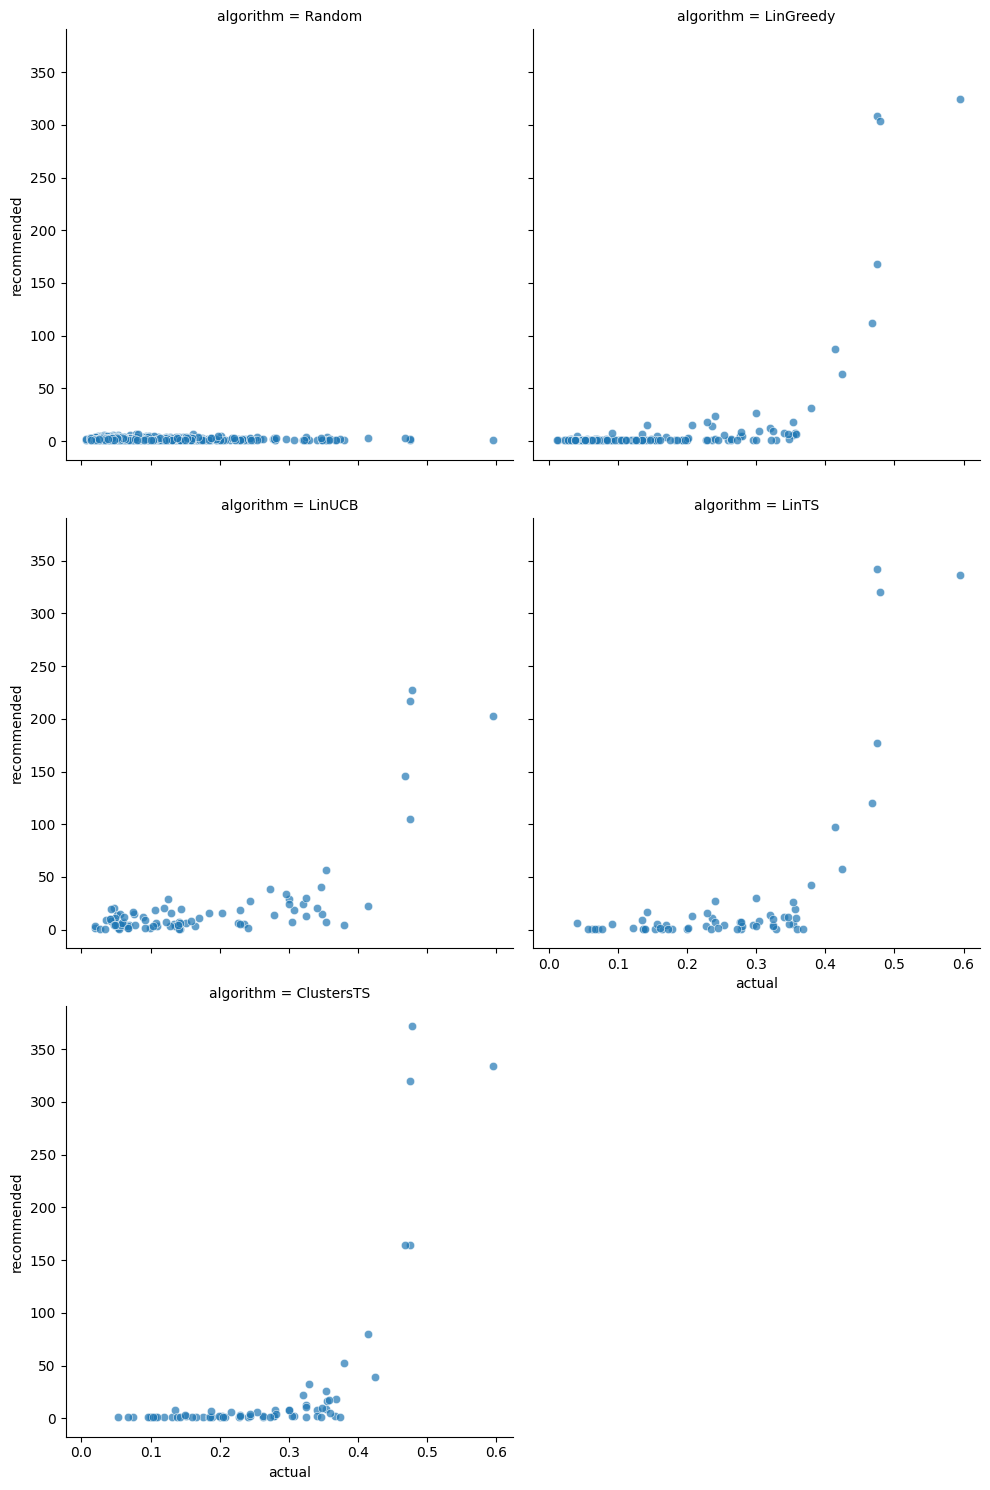

In [112]:
from mab2rec.visualization import plot_recommended_counts

plot_recommended_counts(reco_to_results, data_test, k = 3, alpha = 0.7, average_response = True, col_wrap = 2);


**Recommendation Counts by Item**

These plots show the proportion (when normalize=True) of recommendations (y-axis) allocated to each item (x-axis) for the different algorithms.

The top_n_items parameter controls the number of items in the x-axis. This is helpful when the number of items is too large to display.

As expected, we see that the random baseline recommends each item at the same frequency.

In contrast we note that LinGreedy appears to be exploiting a few items more, with the most recommended item included in ~12% of recommendations.

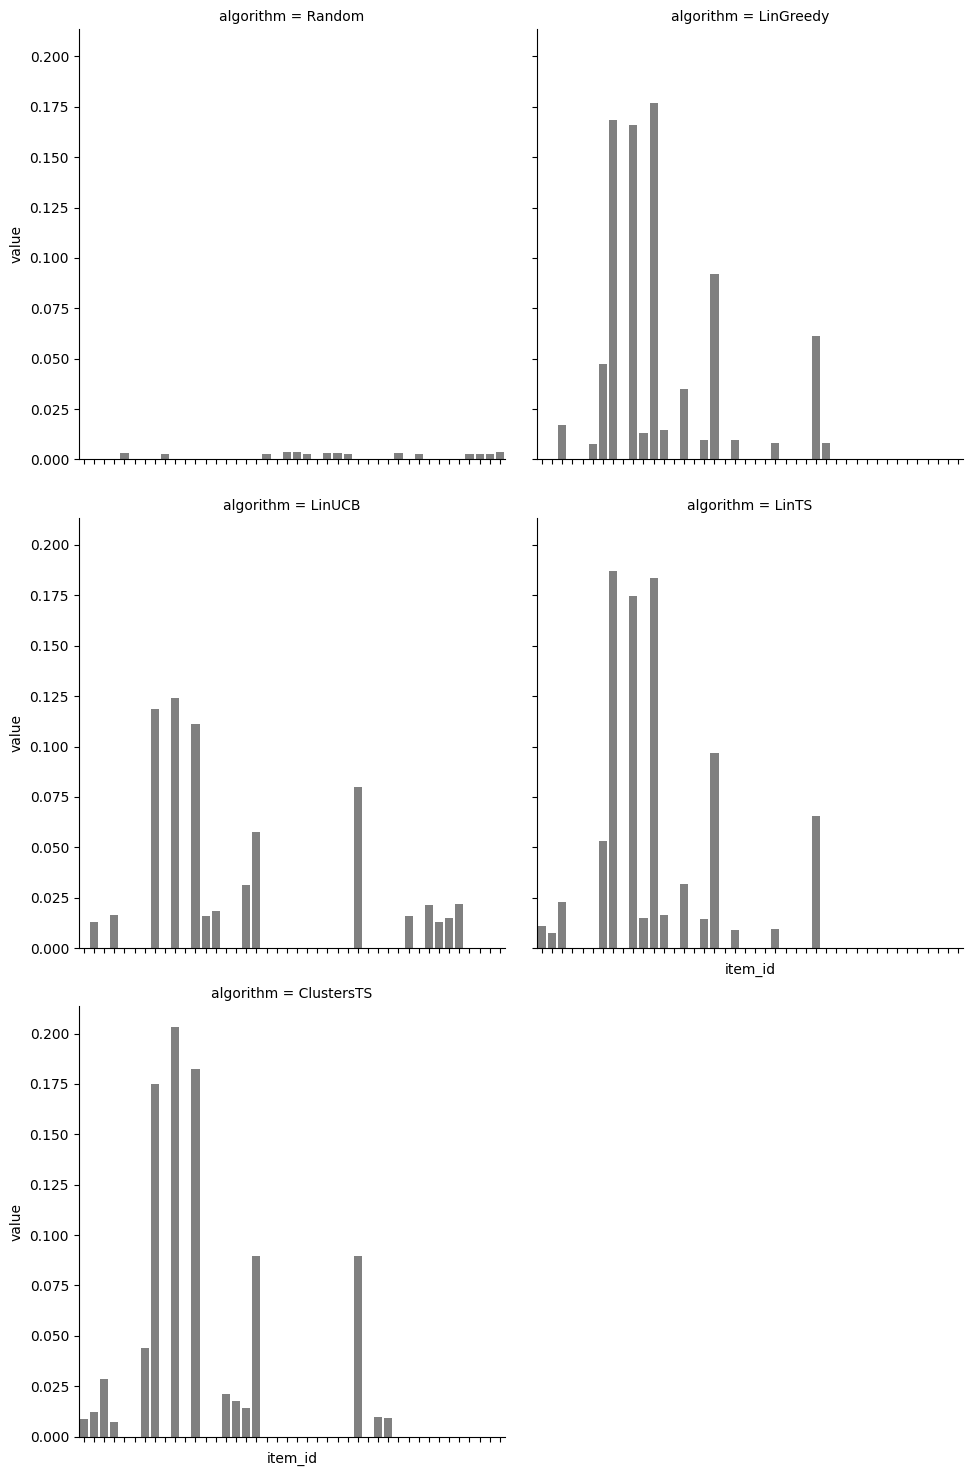

In [113]:
from mab2rec.visualization import plot_recommended_counts_by_item

# Plot recommendation counts (normalize=True)
plot_recommended_counts_by_item(reco_to_results, k=3, top_n_items=15, normalize=True, col_wrap=2);


**Personalization Heatmap**

The heatmaps show how the distribution of recommended items compare between different user clusters.

User clusters are inferred from the user features using a clustering method such as KMeans.

An algorithm with limited personalization will show similar patterns across different clusters.

We notice the most variation across different clusters (see horizontal bars) for LinGreedy and ClustersTS.

This indicates that some items are recommended more/less frequently depending on the user context, i.e., personalization in effect.

As expected, almost no variation (no personalization) for Random.

In [114]:
from sklearn.cluster import KMeans

# Create clusters based on user features
X = users_small.iloc[:, 1:]

kmeans = KMeans(n_clusters=5, random_state=1652)
kmeans.fit(X)

user_clusters = dict(zip(users_small['user_id'], kmeans.labels_))

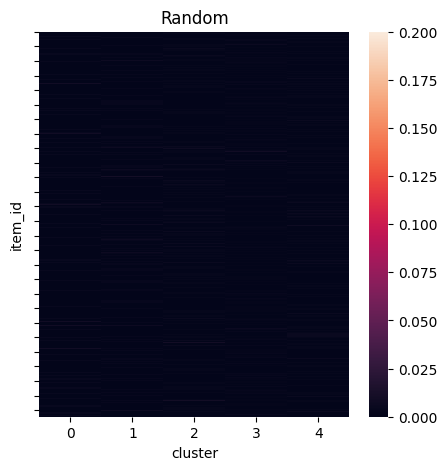

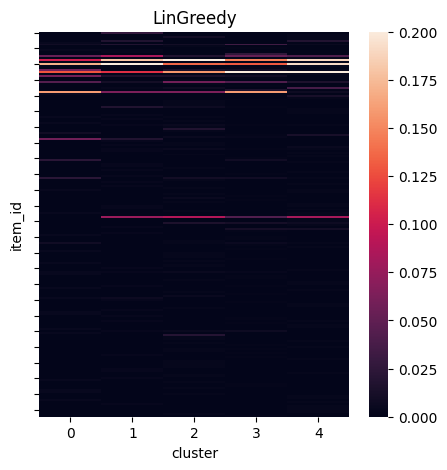

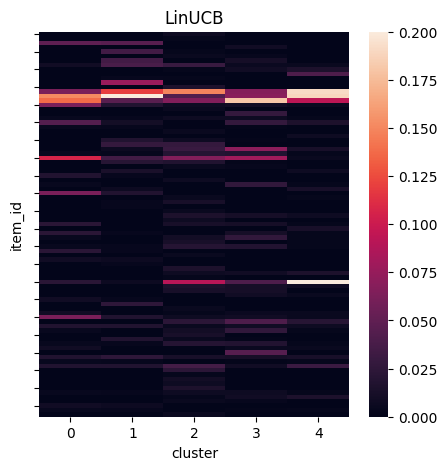

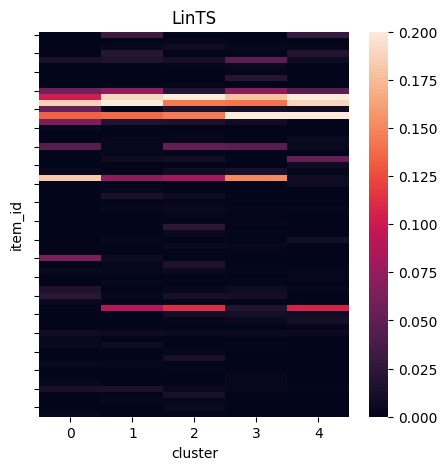

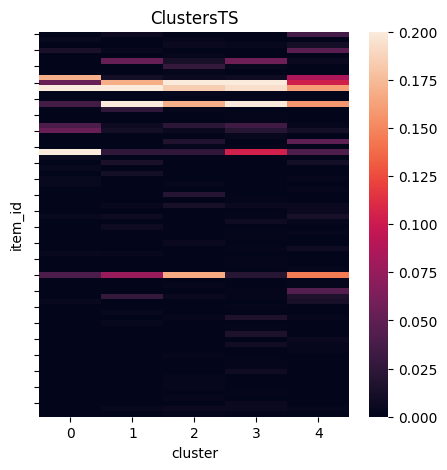

In [116]:
from mab2rec.visualization import plot_personalization_heatmap

plot_personalization_heatmap(reco_to_results, user_clusters, k=3, figsize=(5, 5), vmax=0.2);


**Fairness Metrics**

For a holistic evaluation, we are not only interested in performance results but also fairness and bias metrics.

Recommendation is a multi-class (several items) and multi-label (top-k recommendation) learning task.

Let's assume that we have a binary protected_feature_name and we want to evaluate fairness within the user population.

We first find all predicions based on the LinGreedy algorithm.

Using the is_member relation based on the protected attribute, the predictions are evaluated via MultiClassFairness metrics such as statistical parity and disparate impact.

Finally, we compare the values found to their ideal ranges to uncover potential bias, if any.

In [117]:
from jurity.fairness import MultiClassFairnessMetrics

k = 3
protected_feature_name = "u5"

# Get top-k recommendations for selected algo
results = reco_to_results["LinGreedy"]
results = results.sort_values("score", ascending=False).groupby("user_id").head(k)

# Predicted items by user
predictions = results.groupby("user_id")["item_id"].apply(list)

# Unique items/classes
classes = results["item_id"].unique().tolist()

# Protected attribute
is_member = users_small.set_index("user_id")[protected_feature_name]
is_member = is_member[predictions.index]

# Convert to lists
predictions = predictions.tolist()
is_member = is_member.tolist()

# Fairness metrics to evaluate
statistical_parity_metric = MultiClassFairnessMetrics.StatisticalParity(classes)
disparate_impact_metric = MultiClassFairnessMetrics.DisparateImpact(classes)

# Get scores for each metric
statistical_parity_scores = statistical_parity_metric.get_scores(predictions, is_member)
disparate_impact_scores = disparate_impact_metric.get_scores(predictions, is_member)

# Results
print("Statistical Parity Results:")
print("Ideal Ranges: lb=",
      statistical_parity_metric.lower_bound, " ideal=",
      statistical_parity_metric.ideal_value, " ub=",
      statistical_parity_metric.upper_bound)
print(statistical_parity_scores[0:5])

print("\nDisparate Impact Results:")
print("Ideal Ranges: lb=",
      disparate_impact_metric.lower_bound, " ideal",
      disparate_impact_metric.ideal_value, " ub=",
      disparate_impact_metric.upper_bound)
print(disparate_impact_scores[0:5])

0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class 'int'>
False
0
<class '

# Train & Export

In [121]:
from mab2rec import BanditRecommender, LearningPolicy
from mab2rec.pipeline import train, score

# LinGreedy recommender to select top-4 items with 10% random exploration
rec = BanditRecommender(LearningPolicy.LinGreedy(epsilon=0.1), top_k=4)

# Train on (user, item, response) interactions in train data using user features
rec_pickle = os.path.join('/content/drive/MyDrive/data/bandits rec/pkl', 'recLinGreedy.pkl')
train(recommender=rec,
      data=data_train,
      user_features=user_features,
      save_file=rec_pickle)

# Score recommendations for users in test data. The output df holds
# user_id, item_id, score columns for every test user for top-k items
df = score(recommender=rec_pickle,
           data=data_test,
           user_features=user_features)

df.head()

,user_id,item_id,score
0,505,356,0.642515
1,505,593,0.631240
2,505,480,0.627043
3,505,318,0.615028
4,346,356,0.649869


In [122]:
df.to_csv('/content/drive/MyDrive/data/bandits rec/lin_greedy_results.csv', index = False)

BanditRecommender(learning_policy=LearningPolicy.ThompsonSampling(),
                                       neighborhood_policy = NeighborhoodPolicy.Clusters(n_clusters = 10)

In [126]:
rec = BanditRecommender(LearningPolicy.ThompsonSampling(), neighborhood_policy = NeighborhoodPolicy.Clusters(n_clusters = 10), top_k=4)

# Train on (user, item, response) interactions in train data using user features
rec_pickle = os.path.join('/content/drive/MyDrive/data/bandits rec/pkl', 'recClusters.pkl')
train(recommender=rec,
      data=data_train,
      user_features=user_features,
      save_file=rec_pickle)

# Score recommendations for users in test data. The output df holds
# user_id, item_id, score columns for every test user for top-k items
df1 = score(recommender=rec_pickle,
           data=data_test,
           user_features=user_features)

df1.head()

,user_id,item_id,score
0,505,593,0.657033
1,505,318,0.638232
2,505,260,0.627087
3,505,356,0.626733
4,346,356,0.657213


In [124]:
df1.to_csv('/content/drive/MyDrive/data/bandits rec/clusters_TS_results.csv', index = False)

In [128]:
rec = BanditRecommender(learning_policy=LearningPolicy.LinUCB(alpha=10))

# Train on (user, item, response) interactions in train data using user features
rec_pickle = os.path.join('/content/drive/MyDrive/data/bandits rec/pkl', 'recLinUCB.pkl')
train(recommender=rec,
      data=data_train,
      user_features=user_features,
      save_file=rec_pickle)

# Score recommendations for users in test data. The output df holds
# user_id, item_id, score columns for every test user for top-k items
df2 = score(recommender=rec_pickle,
           data=data_test,
           user_features=user_features)

df2.head()

,user_id,item_id,score
0,505,356,0.918318
1,505,593,0.908534
2,505,457,0.905805
3,505,296,0.904389
4,505,588,0.903736


In [129]:
df2.to_csv('/content/drive/MyDrive/data/bandits rec/LinUCB.csv', index = False)

In [130]:
rec = BanditRecommender(learning_policy=LearningPolicy.LinTS())

# Train on (user, item, response) interactions in train data using user features
rec_pickle = os.path.join('/content/drive/MyDrive/data/bandits rec/pkl', 'LinTS.pkl')
train(recommender=rec,
      data=data_train,
      user_features=user_features,
      save_file=rec_pickle)

# Score recommendations for users in test data. The output df holds
# user_id, item_id, score columns for every test user for top-k items
df3 = score(recommender=rec_pickle,
           data=data_test,
           user_features=user_features)

df3.head()

,user_id,item_id,score
0,505,356,0.610066
1,505,593,0.595115
2,505,480,0.591727
3,505,296,0.579387
4,505,318,0.578424


In [131]:
df3.to_csv('/content/drive/MyDrive/data/bandits rec/LinTS.csv', index = False)